<a href="https://colab.research.google.com/github/carson-edmonds/AAI-520-Chatbot-Project/blob/main/DATA_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import json
import numpy as np
import spacy
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

# Load the English model
nlp = spacy.load("en_core_web_sm")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def squad_json_to_dataframe(file_path, record_path=['data','paragraphs','qas','answers']):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    """

    file = json.loads(open(file_path).read())
    # parsing different level's in the json file
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file,record_path[:-2])

    # combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id','question','context','answers']].set_index('id').reset_index()
    data['c_id'] = data['context'].factorize()[0]
    return data

In [ ]:
#Load QA dataset
filename = "/content/drive/MyDrive/AAI520/PROJECT/train-v1.1.json"
data = squad_json_to_dataframe(filename)

#Check for null entries and view shape of data
print(data.info(),'\n')

#Preview dataset
data.sample(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        87599 non-null  object
 1   question  87599 non-null  object
 2   context   87599 non-null  object
 3   answers   87599 non-null  object
 4   c_id      87599 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.3+ MB
None 



,id,question,context,answers,c_id
50930,57276c675951b619008f89b3,What was the Swiss German name for Schwyz?,The toponym Schwyz itself is first attested in...,"[{'answer_start': 385, 'text': 'Schwiiz'}]",10936
75979,572f34be947a6a140053c7ee,What was one of the names that was initially c...,During the three years following its inception...,"[{'answer_start': 117, 'text': 'Eliot Seminary'}]",16484
26922,57096337ed30961900e84058,When did the era of planning start in Himachal...,The era of planning in Himachal Pradesh starte...,"[{'answer_start': 48, 'text': '1948'}]",6020
82268,57311971497a881900248b69,What do scientists tend to agree on?,The classification of birds is a contentious i...,"[{'answer_start': 259, 'text': 'the assignment...",17779
23415,56fb73b5b28b3419009f1d4e,In what year did the Battle of Lechfeld occur?,The breakup of the Carolingian Empire was acco...,"[{'answer_start': 572, 'text': '955'}]",5242
29684,570b4b85ec8fbc190045b96d,Coalition nations did what with regards to inv...,"After just 100 hours of ground combat, and wit...","[{'answer_start': 609, 'text': 'refused to par...",6584
73729,572f9ff2a23a5019007fc7dd,How many stone pillar-gates survive from the H...,"Though Han wooden structures decayed, some Han...","[{'answer_start': 585, 'text': 'twenty-nine'}]",16002


In [ ]:
#Number of unique documents
print('Number of unique documents:' ,data['c_id'].unique().size)

#Create dataset of documents
documents = data[['context', 'c_id']].drop_duplicates().reset_index(drop=True)
documents.sample(7)

Number of unique documents: 18891


,context,c_id
11787,The main cause of TB is Mycobacterium tubercul...,11787
12740,"""Green"" in modern European languages correspon...",12740
8775,Dutch vocabulary is predominantly Germanic in ...,8775
1652,"On 7 February 2007, the French Parliament pass...",1652
6517,"During the period between 1582, when the first...",6517
18584,"On January 17, 1961, Eisenhower gave his final...",18584
8732,"The term Nederduits, however introduced new co...",8732


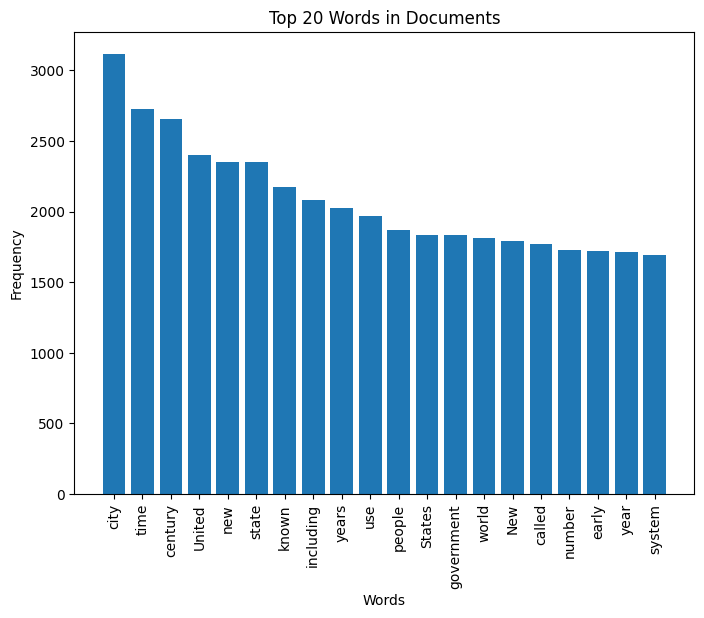

In [ ]:
#Find the most common words/topics in the documents
#Tokenize the text and remove stop words and punctuation
context = []
for x in range(0,len(documents)):
  context.append(documents.iloc[x][0])

tokens = []
words = []
for i in context:
  doc = nlp(i)
  sw = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
  text = ' '.join([str(elem) for elem in sw])
  tokens.append(text)
  for j in sw:
    words.append(j)

all = ' '.join([str(elem) for elem in tokens])

#Identify most frequent words
word_freq = Counter(words)
common_words = word_freq.most_common(20)

#Plot results
pairs = pd.DataFrame(common_words, columns=['Word','Frequency'])
fig, ax = plt.subplots(figsize=(8,6))
plt.bar(pairs['Word'], pairs['Frequency'])
ax.set_title('Top 20 Words in Documents')
ax.set_ylabel('Frequency')
ax.set_xlabel('Words')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Apply NER to documents
#Plot the frequency of each entity in the context
nlp.max_length = 9647555
doc = nlp(all)
labels = [x.label_ for x in doc.ents]
ent_freq = Counter(labels)
common_ents = ent_freq.most_common()

pairs = pd.DataFrame(common_ents, columns=['Entity','Frequency'])
fig, ax = plt.subplots(figsize=(8,6))
plt.bar(pairs['Entity'], pairs['Frequency'])
ax.set_title('Named Entity Frequency in Documents')
ax.set_ylabel('Frequency')
ax.set_xlabel('Entity')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Apply POS tagging to documents
#Plot the frequency of each POS tag in the context
nlp.max_length = 9647555
doc = nlp(all)
tags = [x.pos_ for x in doc]
tag_freq = Counter(tags)
common_tag = tag_freq.most_common(10)

pairs = pd.DataFrame(common_tag, columns=['Tag','Frequency'])
fig, ax = plt.subplots(figsize=(8,6))
plt.bar(pairs['Tag'], pairs['Frequency'])
ax.set_title('POS Tagging Frequency in Documents')
ax.set_ylabel('Frequency')
ax.set_xlabel('POS Tag')
plt.xticks(rotation=90)
plt.show()